# $\Phi$-SO demo

## Packages import

In [1]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [2]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [3]:
torch.cuda.is_available()

False

## Test case

#### Data points

In [4]:
data_size = 50

In [5]:
# Data points
data_lowbound, data_upbound = -10, 10
z  = np.random.uniform(data_lowbound, data_upbound, data_size)
vz = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = z
x1_array = vz
X_array = np.stack((x0_array, x1_array), axis=0)
m = 1.5
g = 9.8
y_array = m*g*z + m*vz**2 #+ 0.5*m*vz**2

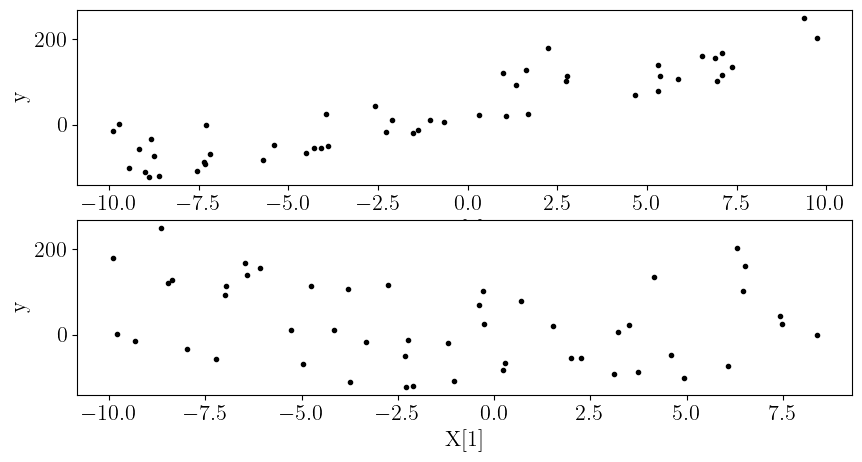

In [6]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

#### Sending data to device

In [7]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)
m = torch.tensor(np.array(m)).to(DEVICE)
g = torch.tensor(np.array(g)).to(DEVICE)

## Run config

### Library config

In [8]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"z" : 0         , "v" : 1         , },
                "input_var_units"      : {"z" : [1, 0, 0] , "v" : [1, -1, 0], },
                "input_var_complexity" : {"z" : 1.        , "v" : 1.        , },
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"m"              , "g"              ,},
                "free_constants_init_val"   : {"m" : 1.         , "g" : 1.         ,},
                "free_constants_units"      : {"m" : [0, 0, 1]  , "g" : [1, -2, 0] ,},
                "free_constants_complexity" : {"m" : 1.         , "g" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [2, -2, 1],
                  "superparent_name"  : "E",
                }

### Learning config

In [9]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [10]:
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [11]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [12]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [13]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 6, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),
                ("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [14]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [15]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 10,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [16]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

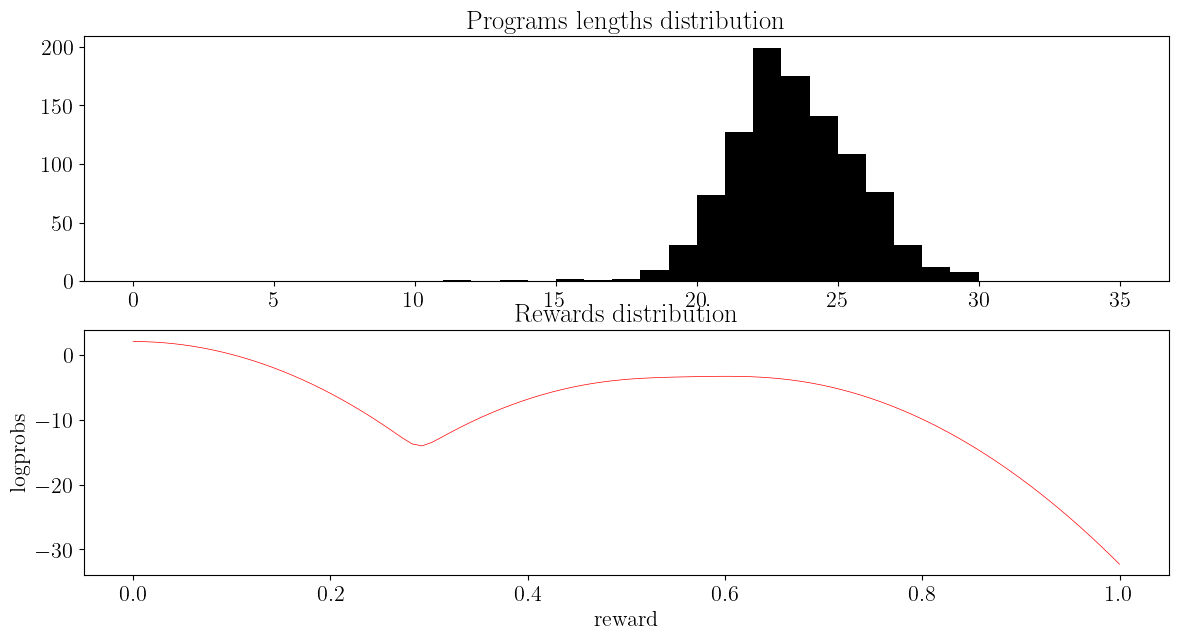

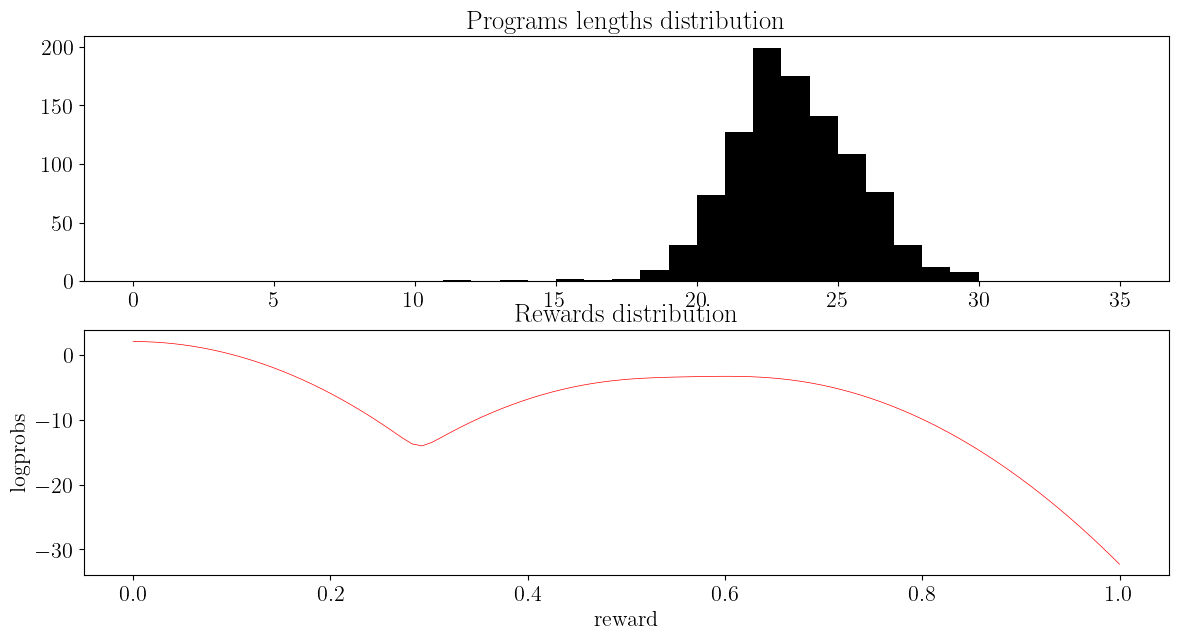

In [17]:
benchmark.dummy_epoch(X, y, run_config)

## Run

In [18]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999, 
                                stop_after_n_epochs = 5)

Unable to make visualisation plots.
Unable to save pareto figure.
=========== Epoch 00000 ===========
-> Time 1.28 s

Overall best  at R=0.620294
-> Raw expression : 
      ⎛     ⎛               2⎞⎞
      ⎜     ⎜⎛ ⎛         2⎞⎞ ⎟⎟
      ⎜     ⎜⎜ ⎜⎛ 0.5  2⎞ ⎟⎟ ⎟⎟
      ⎜     ⎜⎜ ⎝⎝1   ⋅1 ⎠ ⎠⎟ ⎟⎟
      ⎜     ⎝⎝ℯ            ⎠ ⎠⎟
g⋅m⋅z⋅⎝1 + ℯ                  ⎠

Best of epoch at R=0.620294
-> Raw expression : 
      ⎛     ⎛               2⎞⎞
      ⎜     ⎜⎛ ⎛         2⎞⎞ ⎟⎟
      ⎜     ⎜⎜ ⎜⎛ 0.5  2⎞ ⎟⎟ ⎟⎟
      ⎜     ⎜⎜ ⎝⎝1   ⋅1 ⎠ ⎠⎟ ⎟⎟
      ⎜     ⎝⎝ℯ            ⎠ ⎠⎟
g⋅m⋅z⋅⎝1 + ℯ                  ⎠





KeyboardInterrupt



Error in callback <function flush_figures at 0x135b7eca0> (for post_execute):



KeyboardInterrupt



## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


### Complexity - accuracy optimums

In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))